In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import nntools as nt

In [4]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [5]:
vgg = tv.models.vgg19(pretrained=True)

In [6]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
# Define the network with transfer learning

class VGG19Transfer(NNClassifier):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGG19Transfer, self).__init__()
        vgg = tv.models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        # Only maintain the feature space    
        self.net = nn.ModuleList()
        self.net = vgg.features
        # Change MaxPool to AvgPool
        self.net[4] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[9] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[18] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[27] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[36] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
 
    def forward(self, x):
        rep = {}
        rep['c11'] = self.net[0](x)
        rep['r11'] = F.relu(rep['c11'] )
        rep['c12'] = self.net[2](rep['r11'] )
        rep['r12'] = F.relu(rep['r11'] )
        rep['p1'] = self.net[4](rep['c12'] )
        rep['c21'] = self.net[5](rep['p1'] )
        rep['r21'] = F.relu(rep['c21'] )
        rep['c22'] = self.net[7](rep['r21'] )
        rep['r22'] = F.relu(rep['c22'] )
        rep['p2'] = self.net[9](rep['r22'] )
        rep['c31'] = self.net[10](rep['p2'] )
        rep['r31'] = F.relu(rep['c31'] )
        rep['c32'] = self.net[12](rep['r31'] )
        rep['r32'] = F.relu(rep['c32'] )
        rep['c33'] = self.net[14](rep['r32'] )
        rep['r33'] = F.relu(rep['c33'] )
        rep['c34'] = self.net[16](rep['r33'] )
        rep['r34'] = F.relu(rep['c34'] )
        rep['p3'] = self.net[18](rep['r34'] )
        rep['c41'] = self.net[19](rep['p3'] )
        rep['r41'] = F.relu(rep['c41'] )
        rep['c42'] = self.net[21](rep['r41'] )
        rep['r42'] = F.relu(rep['c42'] )
        rep['c43'] = self.net[23](rep['r42'] )
        rep['r43'] = F.relu(rep['c43'] )
        rep['c44'] = self.net[25](rep['r43'] )
        rep['r44'] = F.relu(rep['c44'] )
        rep['p4'] = self.net[27](rep['r44'] )
        rep['c51'] = self.net[28](rep['p4'] )
        rep['r51'] = F.relu(rep['c51'] )
        rep['c52'] = self.net[30](rep['r51'] )
        rep['r52'] = F.relu(rep['c52'] )
        rep['c53'] = self.net[32](rep['r52'] )
        rep['r53'] = F.relu(rep['c53'] )
        rep['c54'] = self.net[34](rep['r53'] )
        rep['r54'] = F.relu(rep['c54'] )
        rep['p5'] = self.net[36](rep['r11'] )
        
        return rep #dictionary data structure; can change if you guys have better ideas

In [8]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [9]:
def Gram(featresp):
    return torch.mm(featresp,featresp.t()) # NlxNl (from paper)

In [24]:
# get images
transform = tv.transforms.Compose([
    tv.transforms.Resize((512)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0,0,0),(1,1,1)),
#     tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
#     tv.transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
#                             std=[1,1,1]),
    tv.transforms.Normalize([0.485, 0.456, 0.406], #mean and std from ImageNet dataset
                        [0.229, 0.224, 0.225]),
    ])

photo_path = 'photo4.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:] # add a singleton dimension for the batch size

art_path = 'art11.jpeg'
art = Image.open(art_path)
a = transform(art)
a = a[None,:,:,:]

p = p.to(device)
a = a.to(device)
net = VGG19Transfer().to(device)

In [29]:
h = p.shape[2]
w = p.shape[3]
x = torch.randn(1,3,h,w,requires_grad=True,device='cuda')  
# x = p
# x.requires_grad=True

<IPython.core.display.Javascript object>


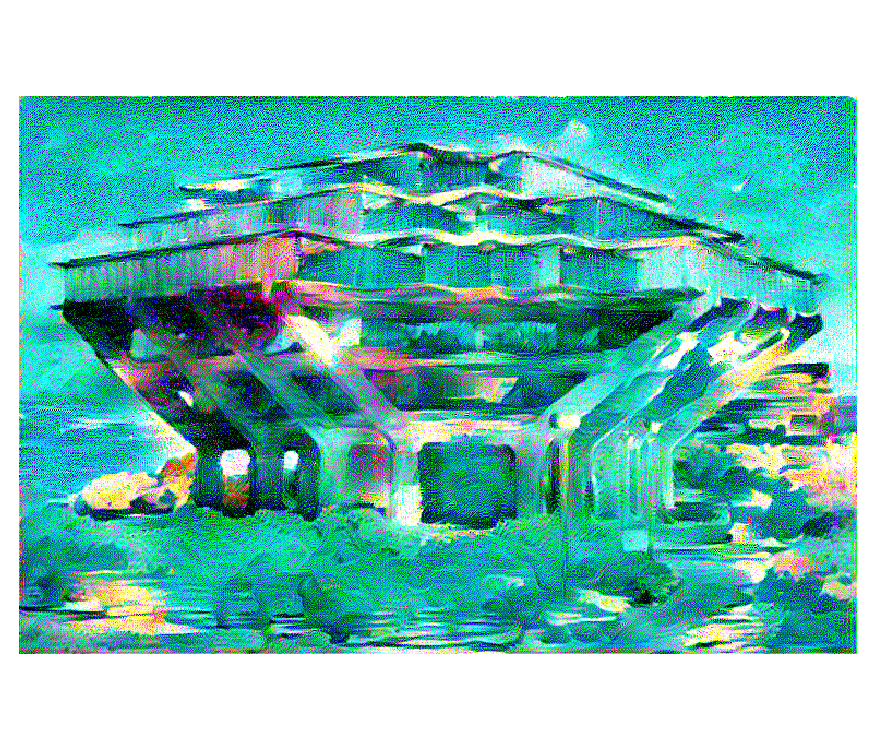

tensor(5446622., device='cuda:0', grad_fn=<AddBackward0>)
0


In [34]:
# transfer the style my dude
epochs = 2

optimizer = torch.optim.Adam([x], lr=0.01, betas=(0.9, 0.999))

P = net.forward(p)
P42NL = P['r42'].shape[1]
P42 = P['r42'].view(P42NL,-1)

A = net.forward(a) 
A1 = A['r11'].view(64,-1)
A2 = A['r21'].view(128,-1)
A3 = A['r31'].view(256,-1)
A4 = A['r41'].view(512,-1)
A5 = A['r51'].view(512,-1)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,6))

for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = net.forward(x)

    out42 = outputs['r42'].view(P42NL, -1)

    out1 = outputs['r11'].view(64,-1)
    out2 = outputs['r21'].view(128,-1)
    out3 = outputs['r31'].view(256,-1)
    out4 = outputs['r41'].view(512,-1)
    out5 = outputs['r51'].view(512,-1)

    #get content loss
    contentloss = net.criterion(out42,P42)/2

    #get style gram matrices
    gram1 = Gram(out1)
    gram2 = Gram(out2)
    gram3 = Gram(out3)
    gram4 = Gram(out4)
    gram5 = Gram(out5)

    gram1o = Gram(A1)
    gram2o = Gram(A2)
    gram3o = Gram(A3)
    gram4o = Gram(A4)
    gram5o = Gram(A5)

    #style loss
    E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * net.criterion(gram1,gram1o)
    E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * net.criterion(gram2,gram2o)
    E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * net.criterion(gram3,gram3o)
    E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * net.criterion(gram4,gram4o)
    E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * net.criterion(gram5,gram5o)

    #total style loss
#         styleloss = E1*1e3/(64**2) + E2*1e3/(128**2) + E3*1e3/(256**2) + E4*1e3/(512**2) + E5*1e3/(512**2)
    styleloss = (E1+E2+E3+E4+E5)/5
#         styleloss = E5

    #get total loss
    loss = contentloss + 130000000*styleloss

    #backprop
    loss.backward(retain_graph=True)

    #parameter search
    optimizer.step()
    
    #display during optimization
    if epoch % 25 == 0:
        print(loss)
        print(epoch)
        axes.clear()
        xx = x.detach().cpu()
        hh = x.shape[2]
        xx = xx.view(3,h,-1)
        myimshow(xx)
    plt.tight_layout()
    fig.canvas.draw()

#     return x

<IPython.core.display.Javascript object>


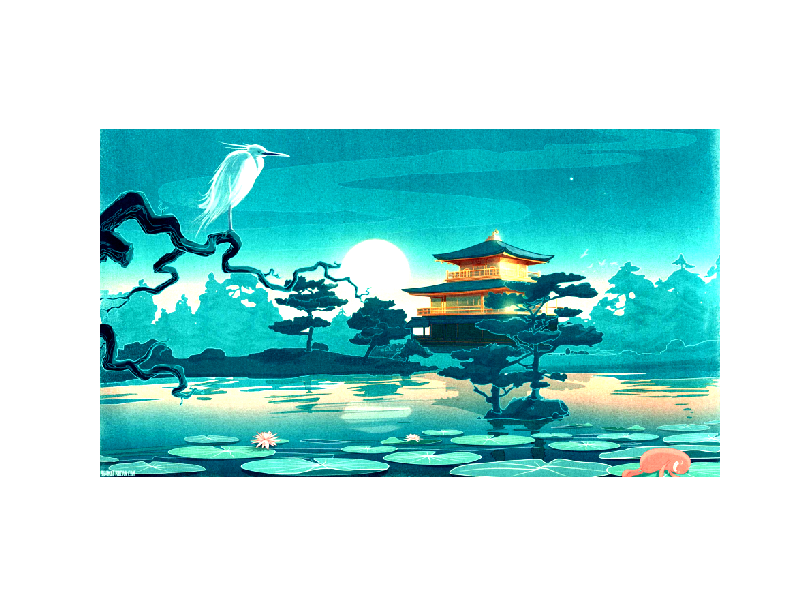

In [33]:
# this is the art
hh = a.shape[2]
myimshow(a.view(3,hh,-1))